In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StringIndexer, StandardScaler
from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier, LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.types import DoubleType


In [2]:
from pyspark.sql import SparkSession

# Krijo një sesion Spark
spark = SparkSession.builder \
    .appName("Combine CSV Files") \
    .getOrCreate()

# Lista e skedarëve të ngarkuar
file_paths = [
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00000-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00001-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00002-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00003-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00004-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00005-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00006-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00007-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv",
    "/Users/elvislleshi/Desktop/DDAM/cleaned_data.csv/part-00008-b3c0df62-e5fd-4925-9d9b-39983222698e-c000.csv"
]

# Lexo dhe bashko të gjitha datasetet
dataframes = [spark.read.csv(file, header=True, inferSchema=True) for file in file_paths]

# Bashko datasetet
df = dataframes[0]
for df in dataframes[1:]:
    df = df.union(df)

# Shfaq rreshtat e para për verifikim
df.show()


24/12/03 01:00:38 WARN Utils: Your hostname, Elviss-MacBook-Air.local resolves to a loopback address: 127.0.0.1; using 192.168.1.57 instead (on interface en0)
24/12/03 01:00:38 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/12/03 01:00:39 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/12/03 01:01:10 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-----+-----+-----------------+----------+--------+-------------------+-------------------+---------+------------------+------------------+--------------------+--------------+-----------+------------+--------------+--------------+-----------------+-----------------+-------+-----+--------+--------+--------+-------+-------+----------+-------+-----+---------------+--------------+------------+--------------+-----------+-----------+----+----+------------------+
|State|Month|Weather_Condition|    County|Severity|         Start_Time|           End_Time|Start_Lat|         Start_Lng|      Distance(mi)|                City|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|Precipitation(in)|Amenity| Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station| Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Civil_Twilight|Day_of_Week|Day_of_Year|Year|Hour|  Traffic_Duration|
+-----+-----+-----------------+----------+--------+-------------------+-------

### Step 1: Verify the Combined Data
Before proceeding, let's inspect the combined dataset for structure and completeness:

In [3]:
# Print the schema to check data types
df.printSchema()

# Count the total number of rows
print(f"Total Rows: {df.count()}")

# Display basic statistics
df.describe().show()

# Check for nulls in each column
from pyspark.sql.functions import col, sum
null_counts = df.select([(sum(col(c).isNull().cast("int"))).alias(c) for c in df.columns])
null_counts.show()


root
 |-- State: string (nullable = true)
 |-- Month: integer (nullable = true)
 |-- Weather_Condition: string (nullable = true)
 |-- County: string (nullable = true)
 |-- Severity: integer (nullable = true)
 |-- Start_Time: timestamp (nullable = true)
 |-- End_Time: timestamp (nullable = true)
 |-- Start_Lat: double (nullable = true)
 |-- Start_Lng: double (nullable = true)
 |-- Distance(mi): double (nullable = true)
 |-- City: string (nullable = true)
 |-- Temperature(F): double (nullable = true)
 |-- Humidity(%): double (nullable = true)
 |-- Pressure(in): double (nullable = true)
 |-- Visibility(mi): double (nullable = true)
 |-- Wind_Direction: string (nullable = true)
 |-- Wind_Speed(mph): double (nullable = true)
 |-- Precipitation(in): double (nullable = true)
 |-- Amenity: boolean (nullable = true)
 |-- Bump: boolean (nullable = true)
 |-- Crossing: boolean (nullable = true)
 |-- Give_Way: boolean (nullable = true)
 |-- Junction: boolean (nullable = true)
 |-- No_Exit: boolean

Total Rows: 543782


+-------+------+-----------------+--------------------+------+------------------+------------------+------------------+------------------+----------+------------------+------------------+------------------+------------------+--------------+-----------------+--------------------+--------------+------------------+-----------------+------------------+------------------+------------------+
|summary| State|            Month|   Weather_Condition|County|          Severity|         Start_Lat|         Start_Lng|      Distance(mi)|      City|    Temperature(F)|       Humidity(%)|      Pressure(in)|    Visibility(mi)|Wind_Direction|  Wind_Speed(mph)|   Precipitation(in)|Civil_Twilight|       Day_of_Week|      Day_of_Year|              Year|              Hour|  Traffic_Duration|
+-------+------+-----------------+--------------------+------+------------------+------------------+------------------+------------------+----------+------------------+------------------+------------------+----------------

+-----+-----+-----------------+------+--------+----------+--------+---------+---------+------------+----+--------------+-----------+------------+--------------+--------------+---------------+-----------------+-------+----+--------+--------+--------+-------+-------+----------+-------+----+---------------+--------------+------------+--------------+-----------+-----------+----+----+----------------+
|State|Month|Weather_Condition|County|Severity|Start_Time|End_Time|Start_Lat|Start_Lng|Distance(mi)|City|Temperature(F)|Humidity(%)|Pressure(in)|Visibility(mi)|Wind_Direction|Wind_Speed(mph)|Precipitation(in)|Amenity|Bump|Crossing|Give_Way|Junction|No_Exit|Railway|Roundabout|Station|Stop|Traffic_Calming|Traffic_Signal|Turning_Loop|Civil_Twilight|Day_of_Week|Day_of_Year|Year|Hour|Traffic_Duration|
+-----+-----+-----------------+------+--------+----------+--------+---------+---------+------------+----+--------------+-----------+------------+--------------+--------------+---------------+---------

In [4]:
from pyspark.sql.functions import when

# Convert binary columns (True/False) to 0/1
binary_cols = [col for col in df.columns if df.select(col).distinct().count() == 2]
for col_name in binary_cols:
    df = df.withColumn(col_name, when(col(col_name) == "True", 1).otherwise(0))


In [5]:
from pyspark.sql.types import DoubleType

# Identify numerical columns
numerical_cols = [col for col in df.columns if isinstance(df.schema[col].dataType, DoubleType)]

# Combine numerical and binary columns
relevant_cols = numerical_cols + binary_cols + ['Severity']
print("Relevant Columns for Correlation Analysis:", relevant_cols)



Relevant Columns for Correlation Analysis: ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Traffic_Duration', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Civil_Twilight', 'Severity']


24/12/03 01:02:17 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
24/12/03 01:02:19 WARN PearsonCorrelation: Pearson correlation matrix contains NaN values.


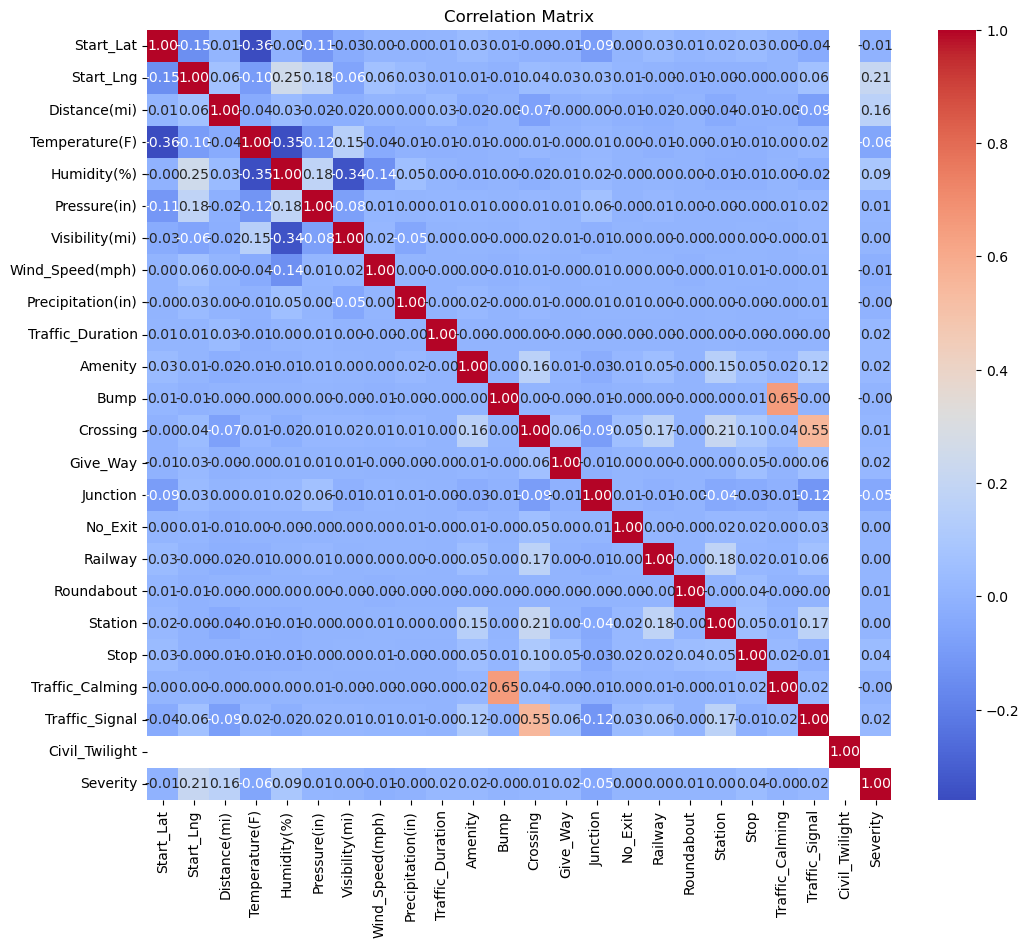

In [6]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assemble relevant columns into a feature vector
assembler = VectorAssembler(inputCols=relevant_cols, outputCol="features")
vectorized_data = assembler.transform(df).select("features")

# Compute the correlation matrix
correlation_matrix = Correlation.corr(vectorized_data, "features").head()[0]

# Convert to numpy array for readability
correlation_array = np.array(correlation_matrix.toArray())

# Create a pandas DataFrame for easier plotting
correlation_df = pd.DataFrame(correlation_array, columns=relevant_cols, index=relevant_cols)

# Plot the correlation heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


### Create Micro Map and Macro Map
Micro Map: Includes only numerical columns.
Macro Map: Includes numerical columns and binary columns (0/1).


In [7]:
# Micro Map: Select numerical columns only
micro_map = df.select(numerical_cols + ['Severity'])

# Macro Map: Combine numerical and binary columns
macro_map = df.select(numerical_cols + binary_cols + ['Severity'])

print(f"Micro Map Columns: {numerical_cols + ['Severity']}")
print(f"Macro Map Columns: {numerical_cols + binary_cols+ ['Severity']}")


Micro Map Columns: ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Traffic_Duration', 'Severity']
Macro Map Columns: ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Traffic_Duration', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Civil_Twilight', 'Severity']


### Normalize Numerical Features 

In [8]:
print(macro_map.columns)


['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Traffic_Duration', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Civil_Twilight', 'Severity']


In [9]:
# Assemble features for Macro Map without Civil_Twilight
macro_assembler = VectorAssembler(inputCols=['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 
                                             'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
                                             'Wind_Speed(mph)', 'Precipitation(in)', 'Traffic_Duration', 
                                             'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
                                             'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 
                                             'Traffic_Calming', 'Traffic_Signal'], 
                                  outputCol="macro_features")


In [10]:
print(df.columns)


['State', 'Month', 'Weather_Condition', 'County', 'Severity', 'Start_Time', 'End_Time', 'Start_Lat', 'Start_Lng', 'Distance(mi)', 'City', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)', 'Precipitation(in)', 'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop', 'Civil_Twilight', 'Day_of_Week', 'Day_of_Year', 'Year', 'Hour', 'Traffic_Duration']


In [11]:
# Transform and scale Macro Map
macro_assembled = macro_assembler.transform(macro_map)
macro_scaler = StandardScaler(inputCol="macro_features", outputCol="scaled_macro_features")
scaled_macro_map = macro_scaler.fit(macro_assembled).transform(macro_assembled)

# Verify scaled features
scaled_macro_map.select("scaled_macro_features").show(5, truncate=False)


+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|scaled_macro_features                                                                                                                                                                                 |
+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|(22,[0,1,2,3,4,5,6,7,9],[7.64617756026685,-4.138468611612862,0.14924423068314002,1.7461775582164818,2.3890455901130427,28.381250899476477,3.0915253757151024,1.5236717440003298,0.051568418227523234])|
|(22,[0,1,3,4,5,6,7,9,21],[7.634666391324984,-4.1430538272521975,2.019017801687807,2.8234175155881416,28.352290439374976,3.0915253757151024,2.176673920000471,0.004297368185626936,3.712458495339881

In [12]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# For Micro Map
micro_assembler = VectorAssembler(inputCols=['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 
                                              'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 
                                              'Traffic_Duration','Severity'], outputCol="micro_features")
micro_scaled = StandardScaler(inputCol="micro_features", outputCol="scaled_micro_features")
scaled_micro_map = micro_scaled.fit(micro_assembler.transform(micro_map)).transform(micro_assembler.transform(micro_map))

macro_assembler = VectorAssembler(inputCols=['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 
                                             'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
                                             'Wind_Speed(mph)', 'Precipitation(in)', 'Traffic_Duration', 
                                             'Amenity', 'Bump', 'Crossing', 'Give_Way', 'Junction', 
                                             'No_Exit', 'Railway', 'Roundabout', 'Station', 'Stop', 
                                             'Traffic_Calming', 'Traffic_Signal'], 
                                  outputCol="macro_features")
macro_scaled = StandardScaler(inputCol="macro_features", outputCol="scaled_macro_features")
scaled_macro_map = macro_scaled.fit(macro_assembler.transform(macro_map)).transform(macro_assembler.transform(macro_map))


### Decision Tree for Micro Map 

In [13]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator


In [14]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator



In [15]:
print(micro_map.columns)


['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 'Wind_Speed(mph)', 'Precipitation(in)', 'Traffic_Duration', 'Severity']


In [16]:
from pyspark.ml.feature import VectorAssembler

# Assemble features for the Micro Map
feature_columns = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 
                   'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
                   'Wind_Speed(mph)', 'Precipitation(in)', 'Traffic_Duration']

assembler = VectorAssembler(inputCols=feature_columns, outputCol="features")
micro_map_prepared = assembler.transform(micro_map)


In [17]:
micro_map_prepared.select("features", "Severity").show(5, truncate=False)


+---------------------------------------------------------------------------+--------+
|features                                                                   |Severity|
+---------------------------------------------------------------------------+--------+
|[40.06695,-75.66226999999998,0.253,32.0,55.0,29.4,10.0,7.0,0.0,360.0]      |2       |
|[40.00663,-75.7461,0.0,37.0,65.0,29.37,10.0,10.0,0.0,30.0]                 |2       |
|[40.00663,-75.7461,0.0,37.0,65.0,29.37,10.0,10.0,0.0,30.0]                 |2       |
|[40.15868,-77.69886,4.579,25.0,39.0,30.51,10.0,9.2,0.0,360.0]              |2       |
|[40.11231,-75.27999,0.398,32.0,55.0,30.13,10.0,9.220321336978788,0.0,360.0]|2       |
+---------------------------------------------------------------------------+--------+
only showing top 5 rows



### Train-Test Split

In [18]:
# Split the prepared dataset into train and test sets
train_micro, test_micro = micro_map_prepared.randomSplit([0.8, 0.2], seed=42)


### Train the Decision Tree:

In [19]:
from pyspark.ml.classification import DecisionTreeClassifier

# Initialize and train the Decision Tree Classifier
dt_micro = DecisionTreeClassifier(featuresCol="features", labelCol="Severity", maxDepth=5)
dt_micro_model = dt_micro.fit(train_micro)


In [20]:
# Make predictions on the test set
micro_predictions = dt_micro_model.transform(test_micro)

# Evaluate the model
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(micro_predictions)
print(f"Decision Tree Accuracy for Micro Map: {accuracy}")


Decision Tree Accuracy for Micro Map: 0.6802579859381055


### Feature Importance

In [21]:
# Train the Decision Tree
dt_micro = DecisionTreeClassifier(featuresCol="features", labelCol="Severity", maxDepth=5)
dt_micro_model = dt_micro.fit(train_micro)


In [22]:
# Get feature importances from the model
feature_importance = dt_micro_model.featureImportances


In [23]:
# Feature names
feature_columns = ['Start_Lat', 'Start_Lng', 'Distance(mi)', 'Temperature(F)', 
                   'Humidity(%)', 'Pressure(in)', 'Visibility(mi)', 
                   'Wind_Speed(mph)', 'Precipitation(in)', 'Traffic_Duration']

# Combine feature names with importance values
importance_dict = {feature: importance for feature, importance in zip(feature_columns, feature_importance)}


In [24]:
# Sort features by importance
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display feature importance
print("Feature Importance (sorted):")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.4f}")


Feature Importance (sorted):
Start_Lng: 0.5755
Distance(mi): 0.2104
Traffic_Duration: 0.1176
Pressure(in): 0.0542
Start_Lat: 0.0422
Temperature(F): 0.0000
Humidity(%): 0.0000
Visibility(mi): 0.0000
Wind_Speed(mph): 0.0000
Precipitation(in): 0.0000


In [25]:
# Sort features by importance
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Display feature importance
print("Feature Importance (sorted):")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.4f}")


Feature Importance (sorted):
Start_Lng: 0.5755
Distance(mi): 0.2104
Traffic_Duration: 0.1176
Pressure(in): 0.0542
Start_Lat: 0.0422
Temperature(F): 0.0000
Humidity(%): 0.0000
Visibility(mi): 0.0000
Wind_Speed(mph): 0.0000
Precipitation(in): 0.0000


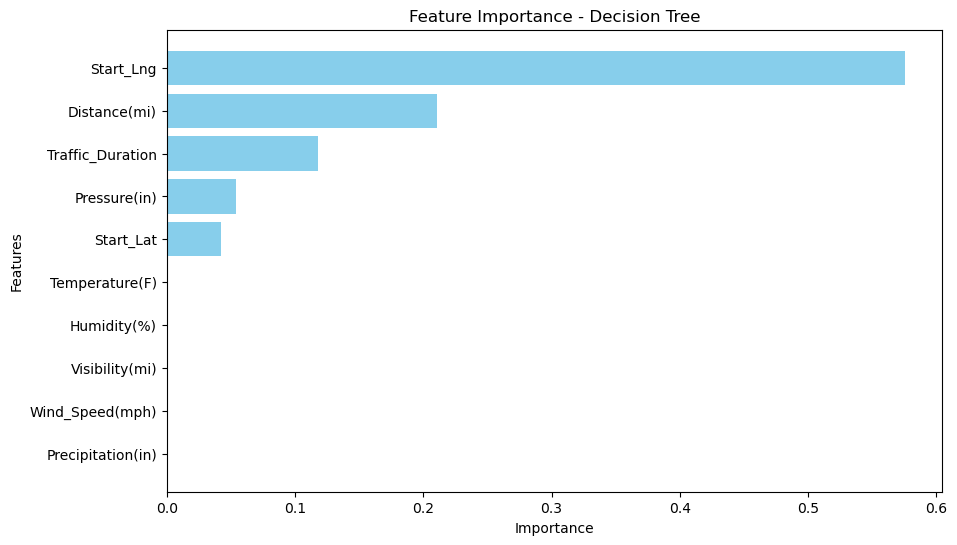

In [26]:
import matplotlib.pyplot as plt

# Extract sorted features and their importances
features, importances = zip(*sorted_importance)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance - Decision Tree")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


### Build and Display Confusion Matrix

In [27]:
# Generate predictions on the test set
micro_predictions = dt_micro_model.transform(test_micro)


In [28]:
from pyspark.sql.functions import col

# Group by actual and predicted labels
confusion_matrix = micro_predictions.groupBy("Severity", "prediction").count()

# Show confusion matrix
confusion_matrix.show()


+--------+----------+-----+
|Severity|prediction|count|
+--------+----------+-----+
|       4|       3.0|  289|
|       2|       4.0| 2067|
|       3|       4.0| 1126|
|       4|       4.0| 3320|
|       2|       3.0|  489|
|       3|       2.0|18024|
|       3|       3.0| 1081|
|       2|       2.0|69324|
|       4|       2.0|12658|
+--------+----------+-----+



In [29]:
# Pivot the confusion matrix for a cleaner display
confusion_matrix_pivot = confusion_matrix.groupBy("Severity").pivot("prediction").sum("count")
confusion_matrix_pivot.show()


+--------+-----+----+----+
|Severity|  2.0| 3.0| 4.0|
+--------+-----+----+----+
|       3|18024|1081|1126|
|       4|12658| 289|3320|
|       2|69324| 489|2067|
+--------+-----+----+----+



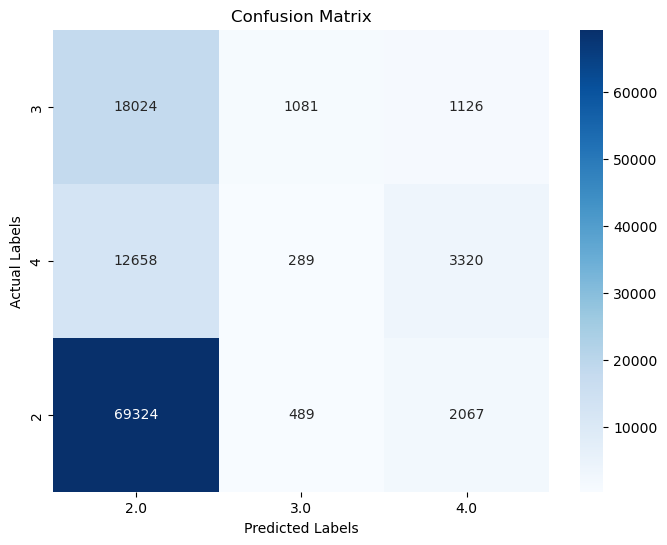

In [30]:
# Convert confusion matrix to Pandas DataFrame
confusion_matrix_pd = confusion_matrix_pivot.toPandas()

# Plot confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Replace NaN with 0 for visualization purposes
confusion_matrix_pd = confusion_matrix_pd.fillna(0)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_pd.set_index("Severity"), annot=True, fmt=".0f", cmap="Blues")
plt.xlabel("Predicted Labels")
plt.ylabel("Actual Labels")
plt.title("Confusion Matrix")
plt.show()


### Calculate Evaluation Metrics

1. Accuracy

In [31]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Initialize evaluator for accuracy
evaluator_accuracy = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")

# Calculate accuracy
accuracy = evaluator_accuracy.evaluate(micro_predictions)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.6803


2. F1-Score 

In [32]:
# Initialize evaluator for F1-Score
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="f1")

# Calculate F1-Score
f1_score = evaluator_f1.evaluate(micro_predictions)
print(f"F1-Score: {f1_score:.4f}")


F1-Score: 0.5970


3. Precision

In [33]:
# Initialize evaluator for Precision
evaluator_precision = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="weightedPrecision")

# Calculate Precision
precision = evaluator_precision.evaluate(micro_predictions)
print(f"Precision: {precision:.4f}")


Precision: 0.6448


In [34]:
# Extract predictions and actual labels into Pandas DataFrame
predictions_df = micro_predictions.select("Severity", "prediction").toPandas()

# Separate labels and predictions
y_true = predictions_df["Severity"]
y_pred = predictions_df["prediction"]


In [35]:
from sklearn.metrics import classification_report

# Generate classification report
report = classification_report(y_true, y_pred, target_names = ["Class 2", "Class 4", "Class 3"])
print(report)


              precision    recall  f1-score   support

     Class 2       0.69      0.96      0.81     71880
     Class 4       0.58      0.05      0.10     20231
     Class 3       0.51      0.20      0.29     16267

    accuracy                           0.68    108378
   macro avg       0.59      0.41      0.40    108378
weighted avg       0.64      0.68      0.60    108378



In [36]:
print("Unique classes in y_true:", y_true.unique())


Unique classes in y_true: [2 4 3]


In [37]:
# Count occurrences of each Severity class in the original dataset
df.groupBy("Severity").count().show()


+--------+------+
|Severity| count|
+--------+------+
|       3|101296|
|       4| 81382|
|       2|361104|
+--------+------+



In [38]:
severity_3 = df.filter(df["Severity"] == 3)
severity_4 = df.filter(df["Severity"] == 4)
oversampled_3 = severity_3.sample(withReplacement=True, fraction=2.0)  # Double the size
oversampled_4 = severity_4.sample(withReplacement=True, fraction=4.0)  # Quadruple the size
balanced_df = df.union(oversampled_3).union(oversampled_4)


### Random Search për Decision Tree (Micro Map)

In [39]:
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.tuning import ParamGridBuilder

# Initialize the Decision Tree classifier
dt_micro = DecisionTreeClassifier(featuresCol="features", labelCol="Severity")

# Define parameter grid
paramGrid = ParamGridBuilder() \
    .addGrid(dt_micro.maxDepth, [3, 5, 7, 10]) \
    .addGrid(dt_micro.maxBins, [16, 32, 64]) \
    .addGrid(dt_micro.minInstancesPerNode, [1, 2, 4]) \
    .build()


In [40]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator

# Define evaluator
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="f1")

# Set up cross-validation
cv = CrossValidator(estimator=dt_micro, 
                    estimatorParamMaps=paramGrid, 
                    evaluator=evaluator, 
                    numFolds=3,  # 3-fold cross-validation
                    parallelism=2,  # Number of parallel tasks
                    seed=42)


In [41]:
# Train the model with cross-validation
cvModel = cv.fit(train_micro)


In [42]:
# Get the best model
bestModel = cvModel.bestModel

# Make predictions on the test set
predictions = bestModel.transform(test_micro)

# Evaluate the best model
f1_score = evaluator.evaluate(predictions)
print(f"Best Model F1-Score: {f1_score:.4f}")

# Print best parameters
print(f"Best Max Depth: {bestModel._java_obj.getMaxDepth()}")
print(f"Best Max Bins: {bestModel._java_obj.getMaxBins()}")


Best Model F1-Score: 0.6548
Best Max Depth: 10
Best Max Bins: 32


In [44]:
# Extract feature importances from the best model
feature_importance = bestModel.featureImportances


In [45]:
# Sort features by importance
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print sorted feature importance
print("Feature Importance (sorted):")
for feature, importance in sorted_importance:
    print(f"{feature}: {importance:.4f}")


Feature Importance (sorted):
Start_Lng: 0.5755
Distance(mi): 0.2104
Traffic_Duration: 0.1176
Pressure(in): 0.0542
Start_Lat: 0.0422
Temperature(F): 0.0000
Humidity(%): 0.0000
Visibility(mi): 0.0000
Wind_Speed(mph): 0.0000
Precipitation(in): 0.0000


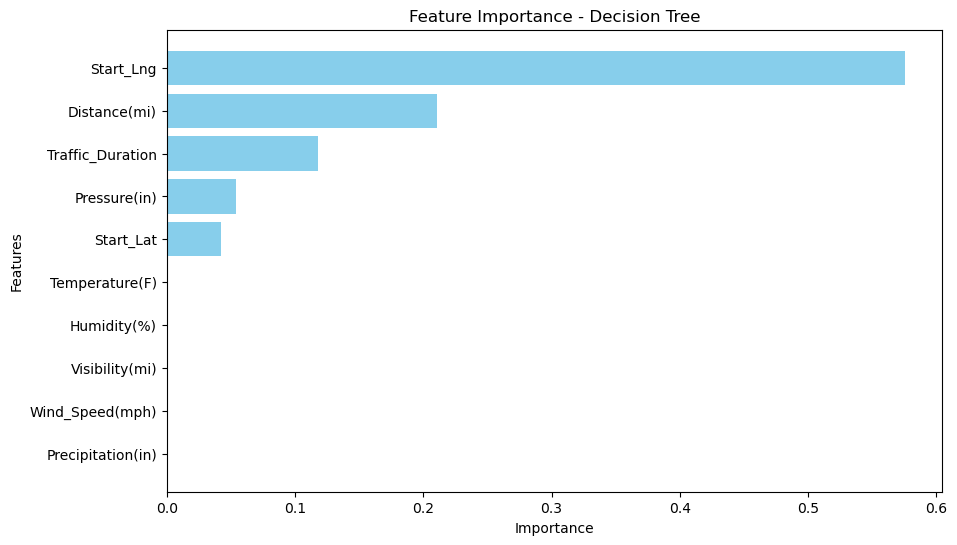

In [46]:
import matplotlib.pyplot as plt

# Extract sorted features and their importances
features, importances = zip(*sorted_importance)

# Plot the feature importance
plt.figure(figsize=(10, 6))
plt.barh(features, importances, color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance - Decision Tree")
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.show()


### Confusion Matrix

In [47]:
# Use the best model to make predictions on the test set
predictions = bestModel.transform(test_micro)

# Display predictions
predictions.select("Severity", "prediction").show(5)


+--------+----------+
|Severity|prediction|
+--------+----------+
|       2|       2.0|
|       4|       2.0|
|       4|       2.0|
|       4|       2.0|
|       4|       4.0|
+--------+----------+
only showing top 5 rows



In [48]:
# Group by actual and predicted labels
confusion_matrix = predictions.groupBy("Severity", "prediction").count()

# Display the confusion matrix
confusion_matrix.show()


+--------+----------+-----+
|Severity|prediction|count|
+--------+----------+-----+
|       4|       3.0|  760|
|       2|       4.0| 2557|
|       3|       4.0| 1347|
|       4|       4.0| 4866|
|       2|       3.0| 2356|
|       3|       2.0|14790|
|       3|       3.0| 4094|
|       2|       2.0|66967|
|       4|       2.0|10641|
+--------+----------+-----+



In [49]:
# Pivot the confusion matrix
confusion_matrix_pivot = confusion_matrix.groupBy("Severity").pivot("prediction").sum("count")

# Replace missing values (if any) with 0 for clarity
confusion_matrix_pivot = confusion_matrix_pivot.fillna(0)

# Show the pivoted confusion matrix
confusion_matrix_pivot.show()


+--------+-----+----+----+
|Severity|  2.0| 3.0| 4.0|
+--------+-----+----+----+
|       3|14790|4094|1347|
|       4|10641| 760|4866|
|       2|66967|2356|2557|
+--------+-----+----+----+



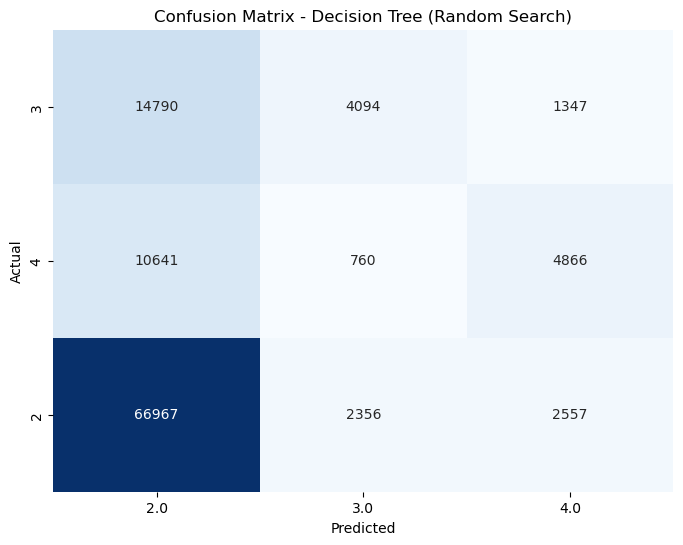

In [50]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the confusion matrix to Pandas DataFrame for visualization
confusion_matrix_df = confusion_matrix_pivot.toPandas()
confusion_matrix_df.set_index("Severity", inplace=True)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Decision Tree (Random Search)")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [51]:
# Use the best model to predict on the test set
predictions = bestModel.transform(test_micro)

# Select columns for evaluation
predictions.select("prediction", "Severity").show(5)


+----------+--------+
|prediction|Severity|
+----------+--------+
|       2.0|       2|
|       2.0|       4|
|       2.0|       4|
|       2.0|       4|
|       4.0|       4|
+----------+--------+
only showing top 5 rows



Compute Test Accuracy and Test Error

In [52]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Test Accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
test_accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Test Error
test_error = 1 - test_accuracy
print(f"Test Error: {test_error:.4f}")


Test Accuracy: 0.7006
Test Error: 0.2994


Compute Validation Accuracy and Validation Error

In [53]:
# Validation metrics from CrossValidator
validation_accuracy = cvModel.avgMetrics[0]  # First metric corresponds to F1 or accuracy used during evaluation
print(f"Validation Accuracy: {validation_accuracy:.4f}")

# Validation Error
validation_error = 1 - validation_accuracy
print(f"Validation Error: {validation_error:.4f}")


Validation Accuracy: 0.5785
Validation Error: 0.4215


#### Additional Metrics

F1-Score for Test Set

In [54]:
# Test F1-Score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="f1")
test_f1_score = f1_evaluator.evaluate(predictions)
print(f"Test F1-Score: {test_f1_score:.4f}")


Test F1-Score: 0.6548


F1-Score for Validation Set:

In [55]:
validation_f1_score = cvModel.avgMetrics[0]  # Assuming F1 was used for evaluation
print(f"Validation F1-Score: {validation_f1_score:.4f}")


Validation F1-Score: 0.5785


In [56]:
print(f"Validation Accuracy: {validation_accuracy:.4f}")
print(f"Validation Error: {validation_error:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Error: {test_error:.4f}")
print(f"Test F1-Score: {test_f1_score:.4f}")


Validation Accuracy: 0.5785
Validation Error: 0.4215
Test Accuracy: 0.7006
Test Error: 0.2994
Test F1-Score: 0.6548


### Random Forest

In [57]:
import itertools
import random
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import matplotlib.pyplot as plt


Random Search for Hyperparameters

In [58]:
# Define hyperparameters
hyperparameters = {
    'numTrees': [25, 50],
    'maxDepth': [6, 9],
    'maxBins': [16, 32, 64],
    'impurity': ['gini', 'entropy']
}

# Number of random combinations to test
number_of_combinations = 12

# Generate random combinations of hyperparameters
random_combinations = random.sample(list(itertools.product(*hyperparameters.values())), number_of_combinations)

# Display random combinations for confirmation
print("Randomly selected parameter combinations:")
for combo in random_combinations:
    print(combo)


Randomly selected parameter combinations:
(50, 9, 16, 'entropy')
(25, 6, 64, 'entropy')
(50, 6, 64, 'gini')
(25, 6, 32, 'gini')
(50, 9, 16, 'gini')
(50, 6, 16, 'gini')
(50, 6, 32, 'entropy')
(50, 6, 32, 'gini')
(25, 9, 64, 'gini')
(25, 6, 16, 'entropy')
(25, 6, 32, 'entropy')
(25, 6, 64, 'gini')


Train and Evaluate Models

24/12/03 01:31:53 WARN DAGScheduler: Broadcasting large task binary with size 1207.9 KiB
24/12/03 01:31:56 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/12/03 01:32:01 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/12/03 01:32:08 WARN DAGScheduler: Broadcasting large task binary with size 1244.8 KiB


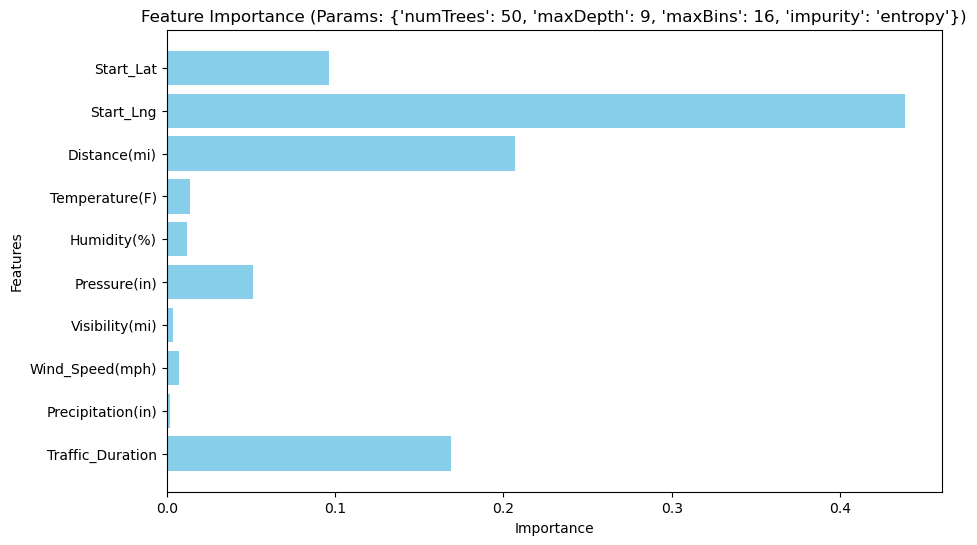

24/12/03 01:32:11 WARN DAGScheduler: Broadcasting large task binary with size 2.7 MiB


With parameters {'numTrees': 50, 'maxDepth': 9, 'maxBins': 16, 'impurity': 'entropy'}, Validation Accuracy: 0.6869


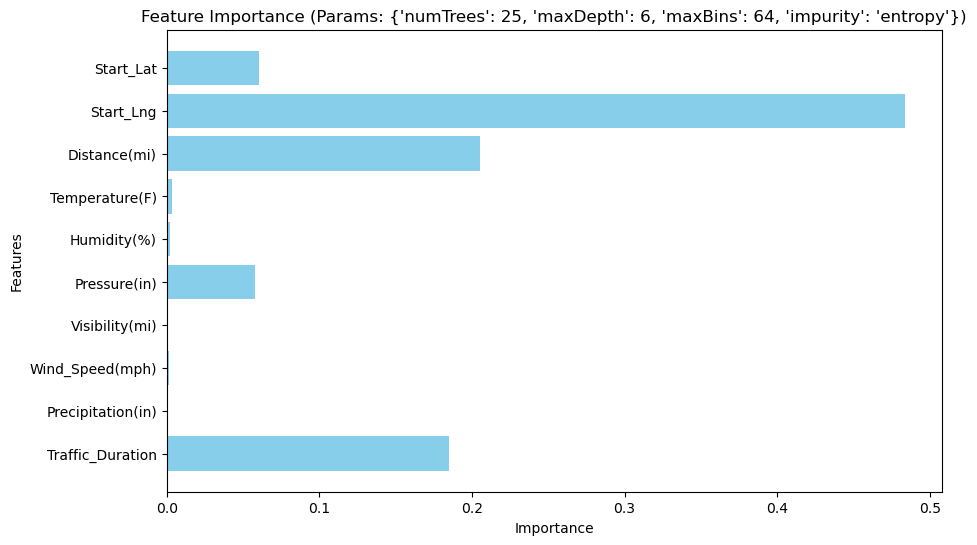

With parameters {'numTrees': 25, 'maxDepth': 6, 'maxBins': 64, 'impurity': 'entropy'}, Validation Accuracy: 0.6789


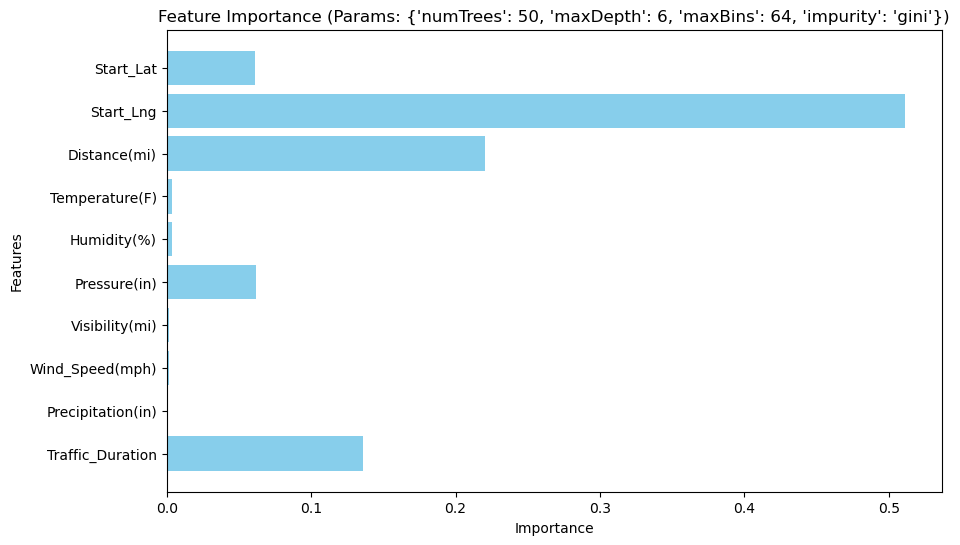

With parameters {'numTrees': 50, 'maxDepth': 6, 'maxBins': 64, 'impurity': 'gini'}, Validation Accuracy: 0.6808


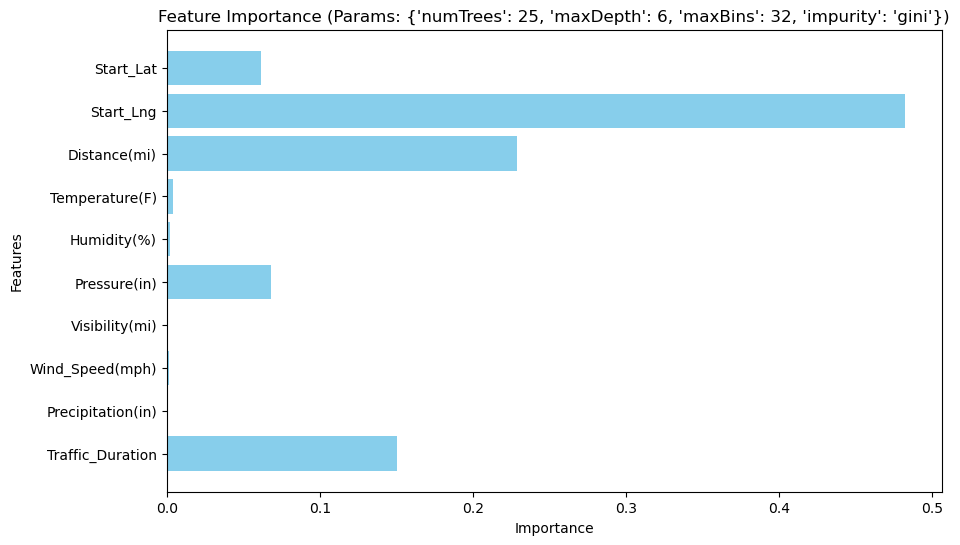

With parameters {'numTrees': 25, 'maxDepth': 6, 'maxBins': 32, 'impurity': 'gini'}, Validation Accuracy: 0.6783


24/12/03 01:32:58 WARN DAGScheduler: Broadcasting large task binary with size 1208.5 KiB
24/12/03 01:33:00 WARN DAGScheduler: Broadcasting large task binary with size 2.3 MiB
24/12/03 01:33:04 WARN DAGScheduler: Broadcasting large task binary with size 4.3 MiB
24/12/03 01:33:09 WARN DAGScheduler: Broadcasting large task binary with size 1237.5 KiB


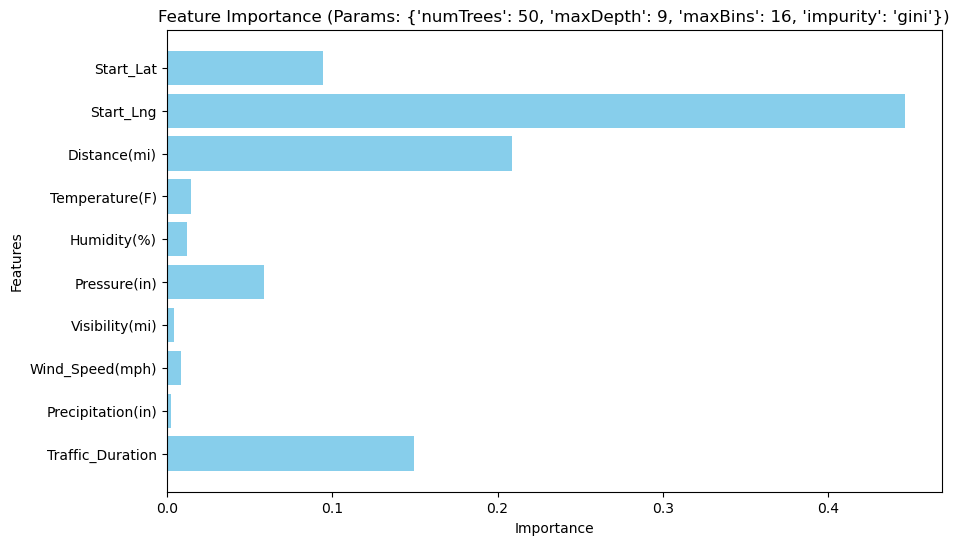

24/12/03 01:33:10 WARN DAGScheduler: Broadcasting large task binary with size 3.0 MiB


With parameters {'numTrees': 50, 'maxDepth': 9, 'maxBins': 16, 'impurity': 'gini'}, Validation Accuracy: 0.6872


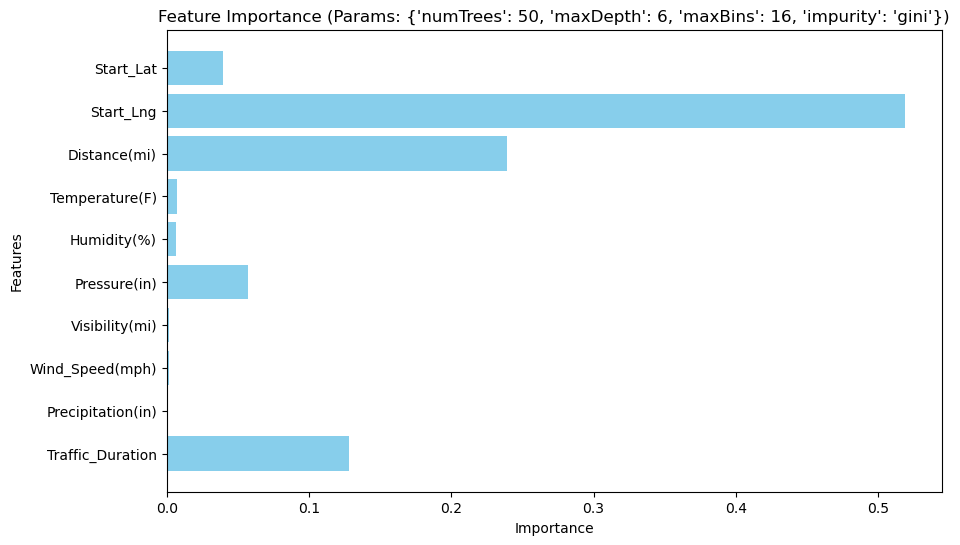

With parameters {'numTrees': 50, 'maxDepth': 6, 'maxBins': 16, 'impurity': 'gini'}, Validation Accuracy: 0.6802


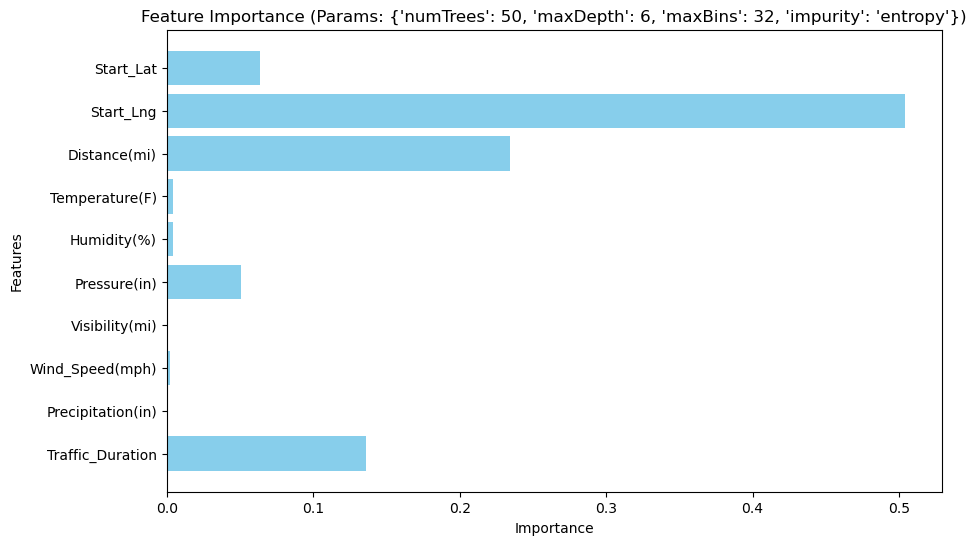

With parameters {'numTrees': 50, 'maxDepth': 6, 'maxBins': 32, 'impurity': 'entropy'}, Validation Accuracy: 0.6797


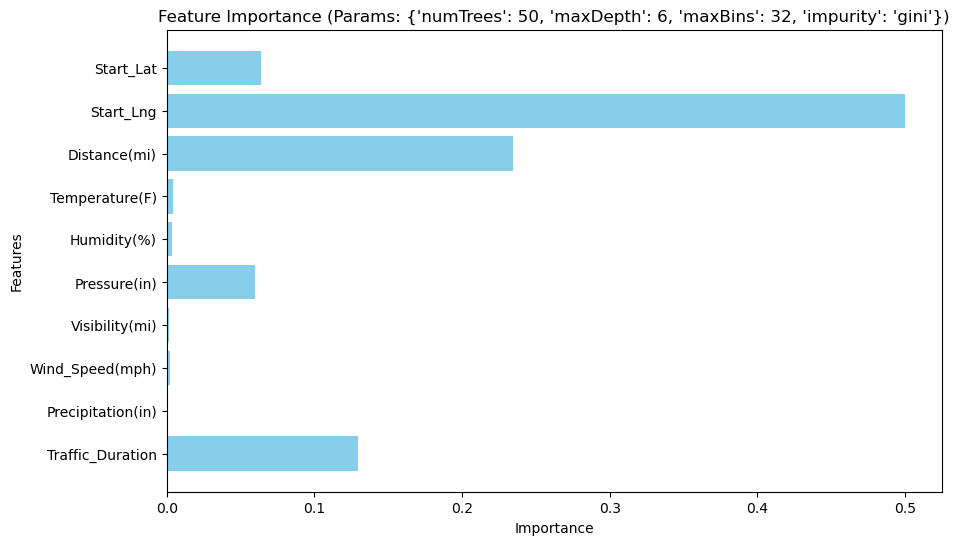

With parameters {'numTrees': 50, 'maxDepth': 6, 'maxBins': 32, 'impurity': 'gini'}, Validation Accuracy: 0.6799


24/12/03 01:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1189.0 KiB
24/12/03 01:34:02 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB


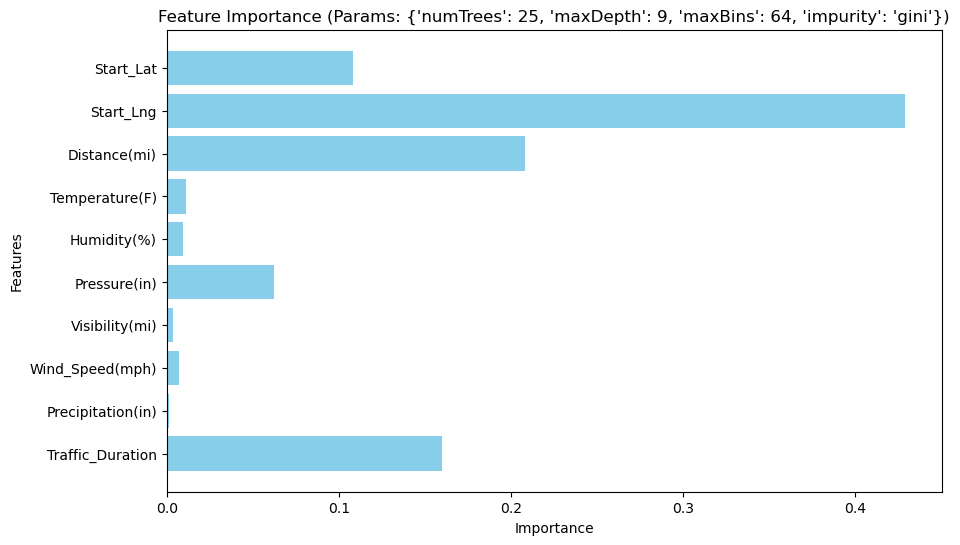

24/12/03 01:34:09 WARN DAGScheduler: Broadcasting large task binary with size 1631.4 KiB


With parameters {'numTrees': 25, 'maxDepth': 9, 'maxBins': 64, 'impurity': 'gini'}, Validation Accuracy: 0.6934


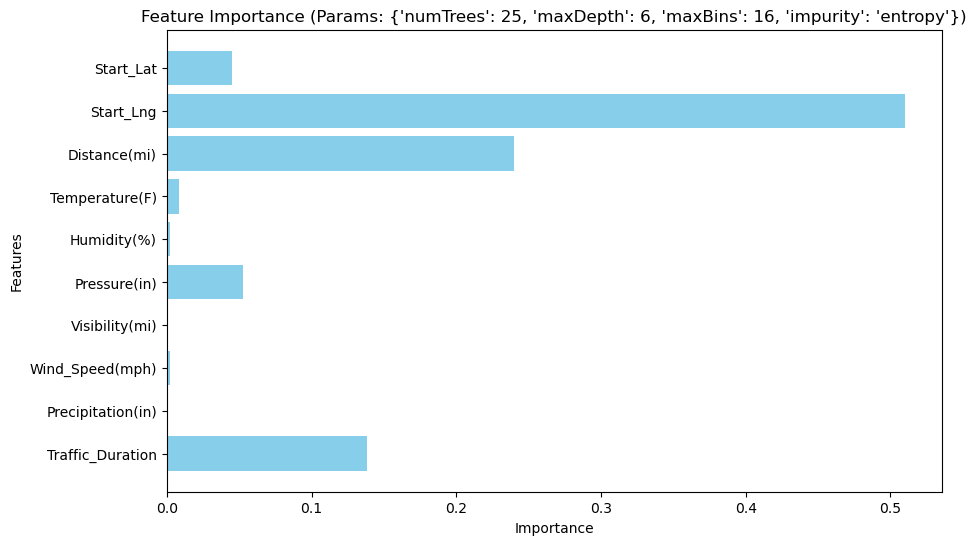

With parameters {'numTrees': 25, 'maxDepth': 6, 'maxBins': 16, 'impurity': 'entropy'}, Validation Accuracy: 0.6805


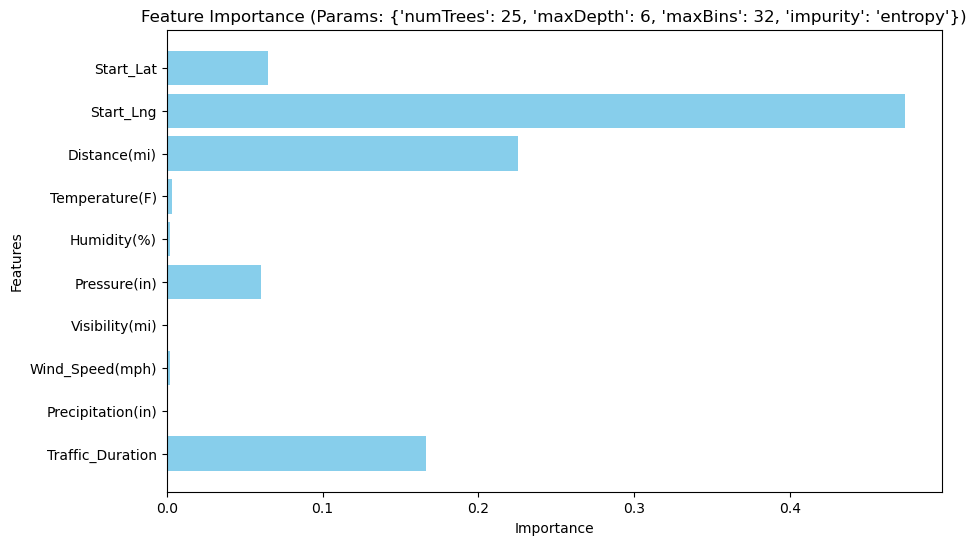

With parameters {'numTrees': 25, 'maxDepth': 6, 'maxBins': 32, 'impurity': 'entropy'}, Validation Accuracy: 0.6791


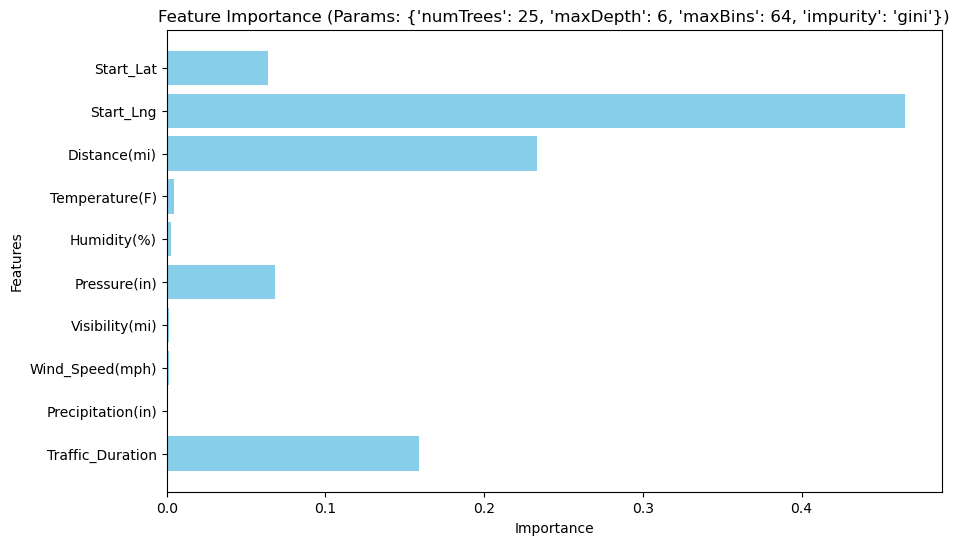

With parameters {'numTrees': 25, 'maxDepth': 6, 'maxBins': 64, 'impurity': 'gini'}, Validation Accuracy: 0.6796


In [59]:
# List to store results
results = []

# Loop over random combinations
for combo in random_combinations:
    # Create parameter dictionary
    param_dict = dict(zip(hyperparameters.keys(), combo))
    
    # Initialize Random Forest with current hyperparameters
    rf = RandomForestClassifier(
        labelCol="Severity",
        featuresCol="features",
        numTrees=param_dict['numTrees'],
        impurity=param_dict['impurity'],
        maxDepth=param_dict['maxDepth'],
        maxBins=param_dict['maxBins']
    )
    
    # Train the model
    rf_model = rf.fit(train_micro)
    
    # Extract feature importance
    feature_importances = rf_model.featureImportances
    importance = {col: imp for col, imp in zip(feature_columns, feature_importances)}

    # Plot feature importance
    plt.figure(figsize=(10, 6))
    plt.barh(list(importance.keys()), list(importance.values()), color="skyblue")
    plt.xlabel("Importance")
    plt.ylabel("Features")
    plt.title(f"Feature Importance (Params: {param_dict})")
    plt.gca().invert_yaxis()
    plt.show()
    
    # Make predictions on validation data
    predictions = rf_model.transform(test_micro)
    
    # Evaluate model accuracy
    evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
    accuracy = evaluator.evaluate(predictions)
    
    # Store results
    results.append((param_dict, accuracy))
    print(f"With parameters {param_dict}, Validation Accuracy: {accuracy:.4f}")


In [60]:
# Find the best combination
best_combo = max(results, key=lambda x: x[1])
print("\nBest Parameters:")
print(best_combo[0])
print(f"Validation Accuracy: {best_combo[1]:.4f}")



Best Parameters:
{'numTrees': 25, 'maxDepth': 9, 'maxBins': 64, 'impurity': 'gini'}
Validation Accuracy: 0.6934


In [70]:
# Train the best model on the full training data
best_rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="Severity",
    numTrees=25,
    maxDepth=9,
    maxBins=64,
    impurity="gini"
)
best_rf_model = best_rf.fit(train_micro)

# Test on the test data
predictions = best_rf_model.transform(test_micro)

# Evaluate performance on test data
evaluator = MulticlassClassificationEvaluator(labelCol="Severity", predictionCol="prediction", metricName="accuracy")
test_accuracy = evaluator.evaluate(predictions)
print(f"Test Accuracy: {test_accuracy:.4f}")


24/12/03 01:49:14 WARN DAGScheduler: Broadcasting large task binary with size 1189.0 KiB
24/12/03 01:49:17 WARN DAGScheduler: Broadcasting large task binary with size 2.1 MiB
24/12/03 01:49:23 WARN DAGScheduler: Broadcasting large task binary with size 1631.2 KiB


Test Accuracy: 0.6934


In [61]:
# Make predictions using the trained Random Forest model
predictions = rf_model.transform(test_micro)

# Display the first 10 predictions along with the true labels
predictions.select("prediction", "Severity", "features").show(10, truncate=False)


+----------+--------+-------------------------------------------------------------------------------------+
|prediction|Severity|features                                                                             |
+----------+--------+-------------------------------------------------------------------------------------+
|2.0       |2       |[24.577545,-81.71765699999997,0.0,84.9,57.0,30.14,10.0,15.0,0.0,360.0]               |
|2.0       |4       |[24.64553,-81.56617,0.0,79.0,66.0,30.13,10.0,5.8,0.0,360.0]                          |
|2.0       |4       |[24.720088,-81.062508,0.0,77.0,69.0,30.04,10.0,9.2,0.0,360.0]                        |
|2.0       |4       |[24.99824,-80.537663,0.235,79.0,65.0,30.04,10.0,13.0,0.0,27.05]                      |
|4.0       |4       |[25.341,-80.41295,7.782999999999999,75.0,94.0,30.07,0.63,0.0,0.0,29.0]               |
|2.0       |2       |[25.47739,-80.44008000000002,0.6990000000000001,78.3,85.0,30.05,10.0,11.5,0.01,360.0]|
|2.0       |2       |[25.494

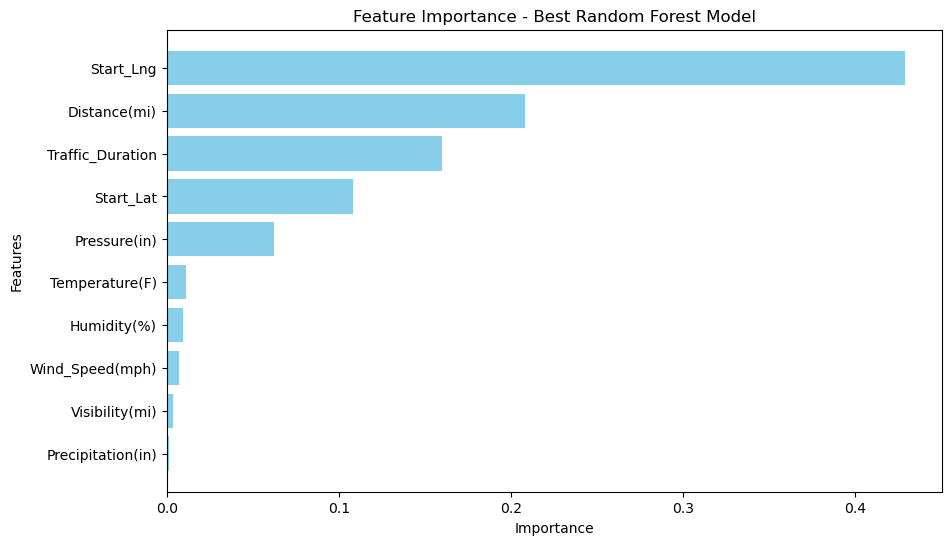

In [71]:
# Extract and visualize feature importance
feature_importances = best_rf_model.featureImportances
importance_dict = {feature: importance for feature, importance in zip(feature_columns, feature_importances)}
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(*zip(*sorted_importance), color="skyblue")
plt.xlabel("Importance")
plt.ylabel("Features")
plt.title("Feature Importance - Best Random Forest Model")
plt.gca().invert_yaxis()
plt.show()


24/12/03 01:51:33 WARN DAGScheduler: Broadcasting large task binary with size 1625.5 KiB
24/12/03 01:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1612.6 KiB
24/12/03 01:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1612.3 KiB
24/12/03 01:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1607.4 KiB
24/12/03 01:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1628.7 KiB
24/12/03 01:51:37 WARN DAGScheduler: Broadcasting large task binary with size 1634.0 KiB
24/12/03 01:51:37 WARN DAGScheduler: Broadcasting large task binary with size 1623.5 KiB


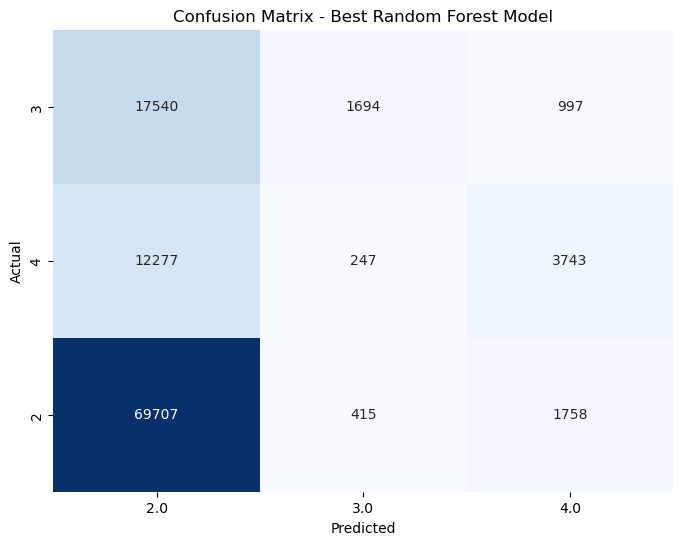

In [73]:
# Confusion matrix
confusion_matrix = predictions.groupBy("Severity", "prediction").count()
confusion_matrix_pivot = confusion_matrix.groupBy("Severity").pivot("prediction").sum("count").fillna(0)

# Convert to Pandas for visualization
confusion_matrix_df = confusion_matrix_pivot.toPandas()
confusion_matrix_df.set_index("Severity", inplace=True)

# Heatmap visualization
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix_df, annot=True, fmt=".0f", cmap="Blues", cbar=False)
plt.title("Confusion Matrix - Best Random Forest Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [74]:
# Group by true label and prediction to create a confusion matrix
confusion_matrix = predictions.groupBy("Severity", "prediction").count()

# Display the confusion matrix
confusion_matrix.show()

# Pivot for a cleaner display
confusion_matrix_pivot = confusion_matrix.groupBy("Severity").pivot("prediction").sum("count").fillna(0)
confusion_matrix_pivot.show()


24/12/03 01:52:09 WARN DAGScheduler: Broadcasting large task binary with size 1628.7 KiB
24/12/03 01:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1611.3 KiB


+--------+----------+-----+
|Severity|prediction|count|
+--------+----------+-----+
|       4|       3.0|  247|
|       2|       4.0| 1758|
|       3|       4.0|  997|
|       4|       4.0| 3743|
|       2|       3.0|  415|
|       3|       2.0|17540|
|       3|       3.0| 1694|
|       2|       2.0|69707|
|       4|       2.0|12277|
+--------+----------+-----+



24/12/03 01:52:11 WARN DAGScheduler: Broadcasting large task binary with size 1625.5 KiB
24/12/03 01:52:12 WARN DAGScheduler: Broadcasting large task binary with size 1612.6 KiB
24/12/03 01:52:12 WARN DAGScheduler: Broadcasting large task binary with size 1612.3 KiB
24/12/03 01:52:12 WARN DAGScheduler: Broadcasting large task binary with size 1607.4 KiB
24/12/03 01:52:13 WARN DAGScheduler: Broadcasting large task binary with size 1628.8 KiB
24/12/03 01:52:14 WARN DAGScheduler: Broadcasting large task binary with size 1634.0 KiB


+--------+-----+----+----+
|Severity|  2.0| 3.0| 4.0|
+--------+-----+----+----+
|       3|17540|1694| 997|
|       4|12277| 247|3743|
|       2|69707| 415|1758|
+--------+-----+----+----+



24/12/03 01:52:14 WARN DAGScheduler: Broadcasting large task binary with size 1624.3 KiB


In [75]:
# Make predictions on the test data
predictions = best_rf_model.transform(test_micro)

# Display the first 10 predictions along with true labels
predictions.select("prediction", "Severity", "features").show(10, truncate=False)


24/12/03 01:52:56 WARN DAGScheduler: Broadcasting large task binary with size 1614.0 KiB


+----------+--------+-------------------------------------------------------------------------------------+
|prediction|Severity|features                                                                             |
+----------+--------+-------------------------------------------------------------------------------------+
|2.0       |2       |[24.577545,-81.71765699999997,0.0,84.9,57.0,30.14,10.0,15.0,0.0,360.0]               |
|2.0       |4       |[24.64553,-81.56617,0.0,79.0,66.0,30.13,10.0,5.8,0.0,360.0]                          |
|2.0       |4       |[24.720088,-81.062508,0.0,77.0,69.0,30.04,10.0,9.2,0.0,360.0]                        |
|2.0       |4       |[24.99824,-80.537663,0.235,79.0,65.0,30.04,10.0,13.0,0.0,27.05]                      |
|4.0       |4       |[25.341,-80.41295,7.782999999999999,75.0,94.0,30.07,0.63,0.0,0.0,29.0]               |
|2.0       |2       |[25.47739,-80.44008000000002,0.6990000000000001,78.3,85.0,30.05,10.0,11.5,0.01,360.0]|
|2.0       |2       |[25.494

In [76]:
from sklearn.metrics import classification_report

# Assuming y_true (actual labels) and y_pred (predicted labels) are extracted from the predictions
y_true = predictions.select("Severity").rdd.flatMap(lambda x: x).collect()  # True labels
y_pred = predictions.select("prediction").rdd.flatMap(lambda x: x).collect()  # Predicted labels

# Generate the classification report
report = classification_report(y_true, y_pred, target_names=["Class 2", "Class 3", "Class 4"], zero_division=0)
print(report)


24/12/03 01:55:56 WARN DAGScheduler: Broadcasting large task binary with size 1617.8 KiB


              precision    recall  f1-score   support

     Class 2       0.70      0.97      0.81     71880
     Class 3       0.72      0.08      0.15     20231
     Class 4       0.58      0.23      0.33     16267

    accuracy                           0.69    108378
   macro avg       0.67      0.43      0.43    108378
weighted avg       0.69      0.69      0.62    108378

